In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

data_path = os.getcwd() + '/Data/'

data = pd.read_csv(data_path + 'vni30.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data = data.set_index(['date'])
data = data.sort_values(['date'])

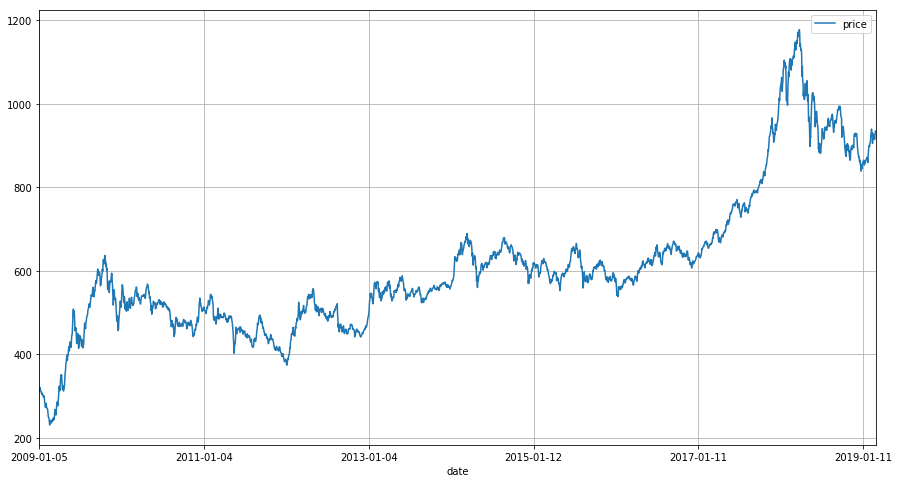

In [2]:
data.plot(figsize=(15,8), grid=True)
plt.show()

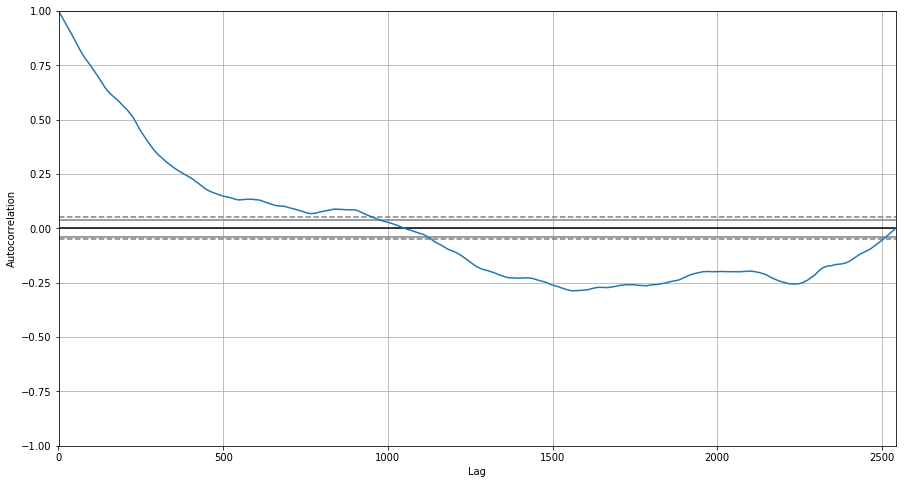

In [3]:
plt.figure(figsize=(15,8))
autocorrelation_plot(data)
plt.show()

In [4]:
# fit model
model = ARIMA(data, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 2541
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8819.084
Method:                       css-mle   S.D. of innovations              7.782
Date:                Fri, 22 Mar 2019   AIC                          17652.168
Time:                        01:08:09   BIC                          17693.050
Sample:                             1   HQIC                         17666.998
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2450      0.184      1.330      0.184      -0.116       0.606
ar.L1.D.price     0.0758      0.020      3.821      0.000       0.037       0.115
ar.L2.D.price     0.0572      0.020     

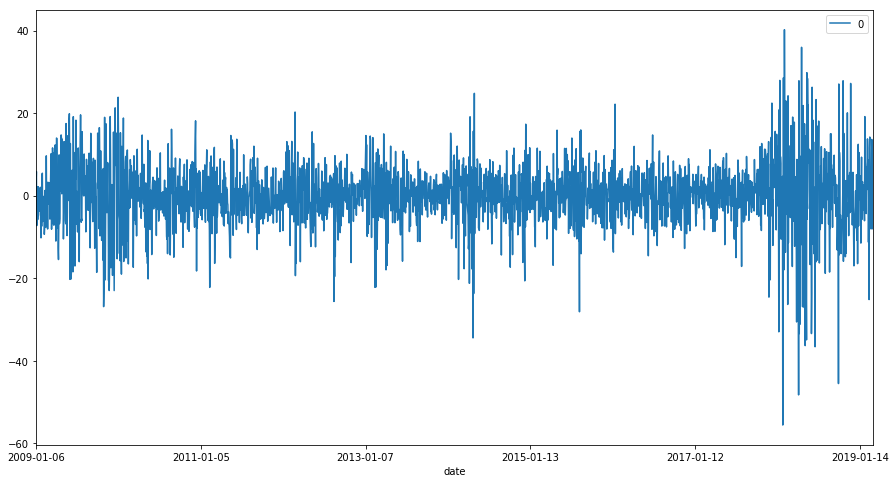

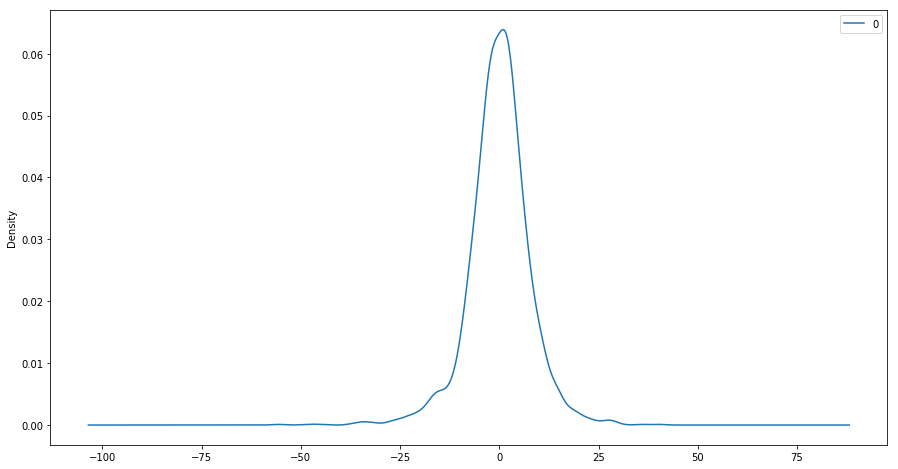

                 0
count  2541.000000
mean     -0.000307
std       7.783210
min     -55.585743
25%      -3.869038
50%       0.219447
75%       4.189251
max      40.243909


In [5]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(15,8))
plt.show()
residuals.plot(figsize=(15,8), kind='kde')
plt.show()
print(residuals.describe())

### One-step prediction

In [11]:
size = len(data)
train_start = int(0.6 * size)
train_end = int(0.9 * size)
train, test = data[train_start:train_end], data[train_end:]
history_data = [price for price in train['price']]
predictions = list()
for t in tqdm(range(len(test)+1)):
    model = ARIMA(history_data, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predictions.append(output[0][0])
    if t < len(test):
        obs = test['price'][t]
        history_data.append(obs)

100%|██████████| 256/256 [00:35<00:00,  7.43it/s]


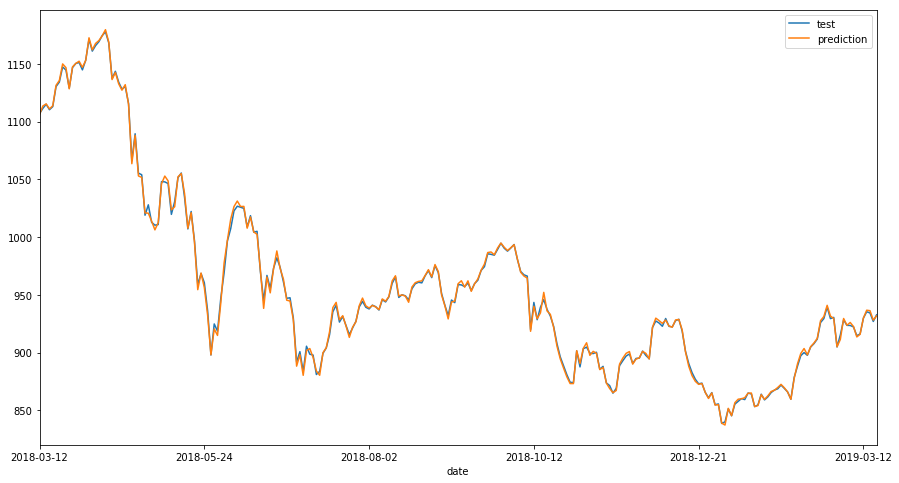

In [12]:
validation = pd.DataFrame()
validation['test'] = test['price']
validation['prediction'] = predictions[1:]
validation.plot(figsize=(15,8))
plt.show()

In [13]:
# Evaluation
mse = mean_squared_error(test['price'], predictions[1:])
print(mse)

4.4747259685393965


### Multi-step prediction

In [9]:
def multi_step_predict(data, n_step=5):
    predictions = list()
    for t in tqdm(range(n_step+1)):
        model = ARIMA(data, order=(5,1,0))
        model_fit= model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0][0]
        predictions.append(yhat)
        if t < n_step:
            data.append(yhat)
    return predictions

100%|██████████| 101/101 [00:12<00:00,  8.14it/s]


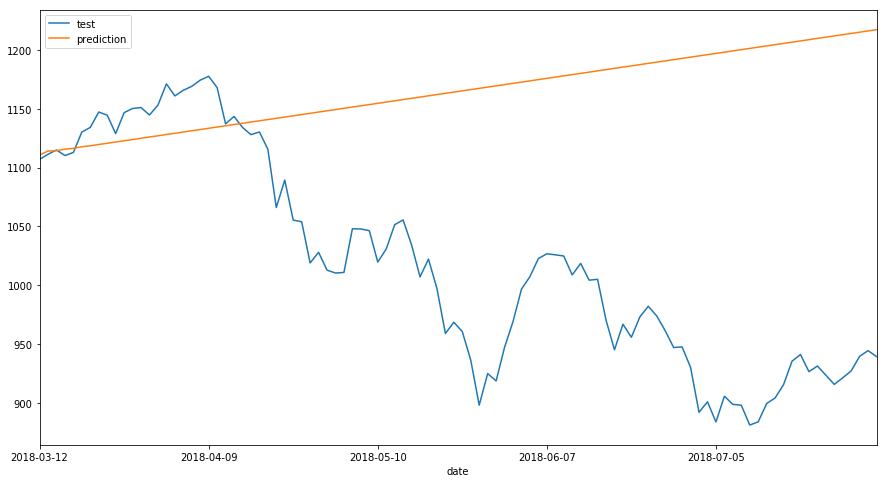

In [10]:
n_step = 100
train, test = data[train_start:train_end], data[train_end:]
history_data = [price for price in train['price']]
predictions = multi_step_predict(history_data, n_step)

validation = pd.DataFrame()
validation['test'] = test['price'][:n_step]
validation['prediction'] = predictions[1:]
validation.plot(figsize=(15,8))
plt.show()